In [1]:
import grid2op
from grid2op.PlotGrid import PlotMatplot
from grid2op.Agent import BaseAgent
from grid2op.Runner import Runner
from grid2op.Agent import DoNothingAgent
import os
import shutil
from grid2op.Parameters import Parameters
import numpy as np

In [2]:
p = Parameters()
p.NO_OVERFLOW_DISCONNECTION = False
env_name  = "educ_case14_storage"
env = grid2op.make(env_name, test=True, param=p)
_ = env.seed(0)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/grid2op/MakeEnv/Make.py:323: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


In [3]:
env.gen_type, env.gen_renewable

(array(['nuclear', 'thermal', 'wind', 'solar', 'solar', 'hydro'],
       dtype='<U10'),
 array([False, False,  True,  True,  True, False]))

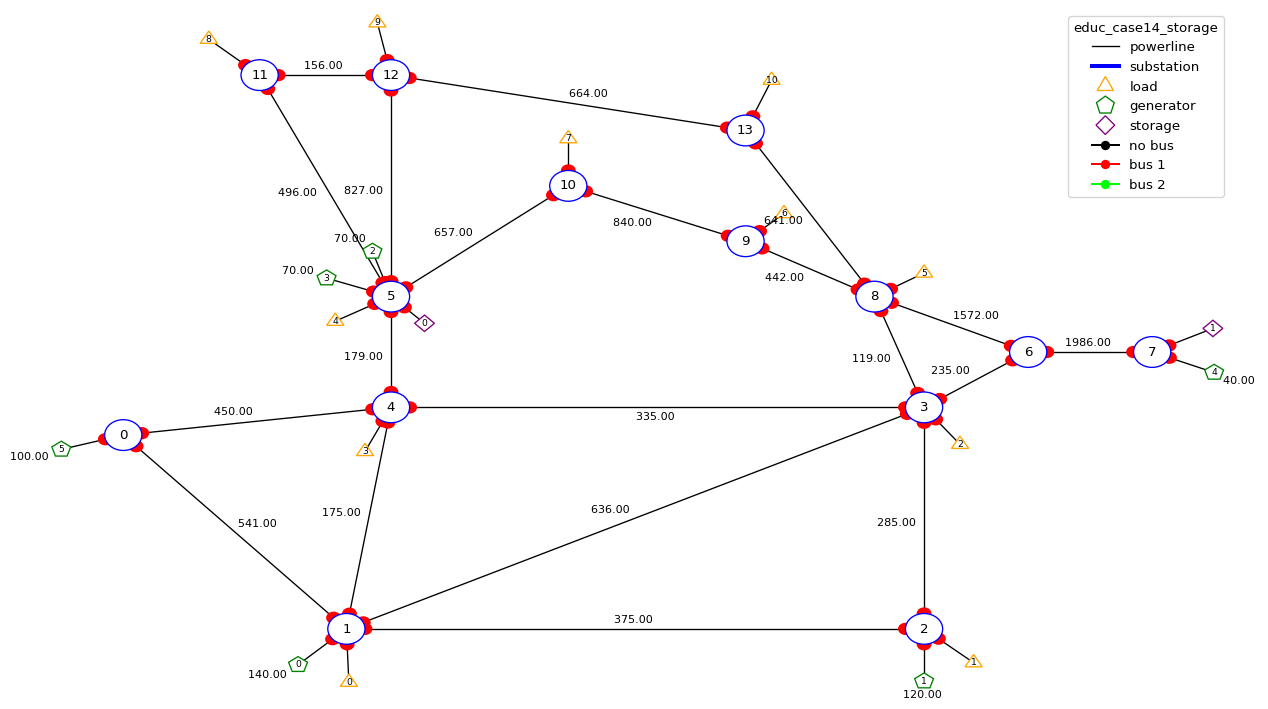

In [4]:
plot_helper = PlotMatplot(env.observation_space)
_ = plot_helper.plot_info(line_values=env._thermal_limit_a, gen_values=env.gen_pmax)

In [5]:
def test_agent(agent_class, agent_name, env, nb_episode=1):

  path_this_agent = os.path.join("output_agents", agent_name)
  shutil.rmtree(os.path.abspath(path_this_agent),ignore_errors=True)
  runner = Runner(**env.get_params_for_runner(), agentClass=agent_class)

  res = runner.run(nb_episode=nb_episode, path_save=path_this_agent)

  print(f"The results for the {agent_name} agent are:")
  for _, chron_name, cum_reward, nb_time_step, max_ts in res:
      msg_tmp = "\tFor chronics with id {}\n".format(chron_name)
      msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
      msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
      print(msg_tmp)

In [6]:
env.reset()

In [7]:
action = env.action_space({})
action.redispatch = [(gen, 5) for gen in range(env.n_gen) if env.gen_redispatchable[gen]]

obs = env.step(action)[0]

In [8]:
obs.actual_dispatch

array([ 2.5571067, -0.7185211,  0.       ,  0.       ,  0.       ,
       -1.8385855], dtype=float32)

In [9]:
action = env.action_space({})
action.redispatch = [(gen, -obs.target_dispatch[gen]) for gen in range(obs.n_gen) if obs.gen_redispatchable[gen]]
obs = env.step(action)[0]

In [10]:
obs.actual_dispatch

array([ 0.000000e+00,  9.609209e-09,  0.000000e+00,  0.000000e+00,
        0.000000e+00, -4.281536e-08], dtype=float32)

In [12]:
obs = env.step(env.action_space({}))[0]
obs.actual_dispatch

array([ 0.000000e+00,  9.609209e-09,  0.000000e+00,  0.000000e+00,
        0.000000e+00, -4.281536e-08], dtype=float32)

In [17]:
class ExpertAgent(BaseAgent):
  def __init__(self, action_space):
    # python required method to code
    BaseAgent.__init__(self, action_space)
    self.do_nothing = self.action_space({})
    self.print_next = True
        
  def act(self, obs, reward, done=False):
    max_rho = np.max(obs.rho)
    action = self.action_space({})

    if max_rho < 0.90:
      # Charger les batteries
      mask = (obs.storage_charge / obs.storage_Emax) > 0.90
      batteries_to_charge = np.where(mask)[0]
      action.storage_p = [(battery, obs.storage_max_p_absorb[battery]) for battery in batteries_to_charge]

      # Reset redispatching
      action.redispatch = [(gen, -obs.target_dispatch[gen]) for gen in range(obs.n_gen) if obs.gen_redispatchable[gen]]


    # Simulate our action
    _, _, done, _ = obs.simulate(action)

    if done:
      return self.do_nothing
    else: return action

In [18]:
test_agent(ExpertAgent, "Expert", env, nb_episode=7)

test
test
test
test
test
The results for the Expert agent are:
	For chronics with id 2019-01-12
		 - cumulative reward: 4688.167480
		 - number of time steps completed: 288 / 288
	For chronics with id 2019-01-13
		 - cumulative reward: 4685.237305
		 - number of time steps completed: 288 / 288
	For chronics with id 2019-01-14
		 - cumulative reward: 3330.406250
		 - number of time steps completed: 219 / 288
	For chronics with id 2019-01-15
		 - cumulative reward: 1374.079468
		 - number of time steps completed: 89 / 288
	For chronics with id 2019-01-16
		 - cumulative reward: 3609.946533
		 - number of time steps completed: 235 / 288
	For chronics with id 2019-01-17
		 - cumulative reward: 3533.431396
		 - number of time steps completed: 233 / 288
	For chronics with id 2019-01-18
		 - cumulative reward: 1267.627197
		 - number of time steps completed: 85 / 288


In [20]:
test_agent(DoNothingAgent, "DN", env, nb_episode=7)

The results for the DN agent are:
	For chronics with id 2019-01-12
		 - cumulative reward: 4688.167480
		 - number of time steps completed: 288 / 288
	For chronics with id 2019-01-13
		 - cumulative reward: 4685.237305
		 - number of time steps completed: 288 / 288
	For chronics with id 2019-01-14
		 - cumulative reward: 3330.406250
		 - number of time steps completed: 219 / 288
	For chronics with id 2019-01-15
		 - cumulative reward: 1374.079468
		 - number of time steps completed: 89 / 288
	For chronics with id 2019-01-16
		 - cumulative reward: 3609.946533
		 - number of time steps completed: 235 / 288
	For chronics with id 2019-01-17
		 - cumulative reward: 3533.431396
		 - number of time steps completed: 233 / 288
	For chronics with id 2019-01-18
		 - cumulative reward: 1267.627197
		 - number of time steps completed: 85 / 288
